Importando los módulos necesario

In [7]:
!pip install fer

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from numpy.linalg import norm
from fer import FER
import matplotlib.pyplot as plt 
import cv2

Cargar información del Usuario

In [17]:
top_artist_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/top_artists.pkl?raw=true')
top_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/top_tracks.pkl?raw=true')
saved_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/saved_tracks.pkl?raw=true')
playlist_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/playlist_tracks.pkl?raw=true')
recommendation_tracks_df = pd.read_pickle(r'https://github.com/joseisaias06/FER_Spotify_Recommender/blob/main/spotify_data/data_user1/recommendation_tracks.pkl?raw=true')

with open(r'C:\Users\luisg\Downloads\spotify-recommender-systems-main\local\playlists.yml') as stream:
    playlists = yaml.safe_load(stream)


In [18]:
# Eliminar duplicados en el ID
playlist_tracks_df = playlist_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
recommendation_tracks_df = recommendation_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
# Prevenir data leakage
recommendation_tracks_df = recommendation_tracks_df[~recommendation_tracks_df['id'].isin(playlist_tracks_df['id'].tolist())]

Para evitar tener que etiquetar todas las canciones que tenemos del 1 al 10. Lo hacemos como un problema de clasificación.
Tendremos un 1 para las canciones que estén dentro de nuestras más escuchadas, que sean de nuestros artistas más escuchados o estén guardadas. Y un 0 de otro modo.

In [19]:
saved_tracks_list = list(saved_tracks_df['id'])
top_tracks_list = list(top_tracks_df['id'])
top_artist_list = list(top_artist_df['id'])

playlist_tracks_df['ratings'] = playlist_tracks_df['id'].apply(lambda x: 1 if x in top_tracks_list else 0)
playlist_tracks_df['ratings'] = playlist_tracks_df.apply(lambda x: 1 if x['artist_id'] in top_artist_list else x.ratings, axis=1)
playlist_tracks_df['ratings'] = playlist_tracks_df.apply(lambda x: 1 if x['id'] in saved_tracks_list else x.ratings, axis=1)

Crear los datos de entrenamiento y de prueba

In [20]:
# Training data
X = playlist_tracks_df[['popularity', 'explicit', 'duration_ms', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'tempo', 'time_signature', 'genres']]  # order here is important for xgboost later
y = playlist_tracks_df['ratings']

# Drop NA
X = X.dropna()
recommendation_tracks_df = recommendation_tracks_df.dropna()

# Crear columnas de géneros (one-hot encoding)
X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
X_recommend = recommendation_tracks_df.copy()
X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())

# Asegurarse de que las características sean consistentes en el entrenamiento, la prueba y la evaluación
X = X[X.columns.intersection(X_recommend.columns)]
X_recommend = X_recommend[X_recommend.columns.intersection(X.columns)]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\luisg\AppData\Local\Temp\ipykernel_17660\725810985.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
C:\Users\luisg\AppData\Local\Temp\ipykernel_17660\725810985.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())


Hacer Cross Validation para obtener el mejor número de características

Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Optimal number of features: 165


c:\Users\luisg\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


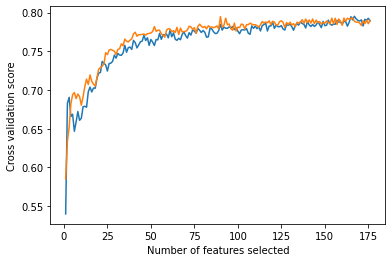

In [21]:
# Cross-validation for number of features 
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfecv = RFECV(estimator=rf, step=1, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

In [22]:
# Obtener las características más importantes
# Can use this with previous rfecv to reduce the number of features to speed up model training if needed 
rfc = RandomForestClassifier(n_estimators = 1000, max_depth=4, random_state=42, max_features=130)
rfc.fit(X_train, y_train)

important_features_dict = {}
for idx, val in enumerate(rfc.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
for i in range(len(important_features_list[:80])):
    print(f"{i+1}. {X_train.columns[important_features_list[i]]} {important_features_dict[important_features_list[i]]}")

1. acousticness 0.14691808343169793
2. loudness 0.12646088804053873
3. duration_ms 0.10248284505463302
4. corrido 0.08237992582955662
5. instrumentalness 0.06464331927346294
6. popularity 0.04428878771964202
7. valence 0.03677124970138121
8. tempo 0.032613882821950116
9. trap latino 0.03239060202208191
10. danceability 0.027191811547794747
11. liveness 0.02582575526896965
12. energy 0.024426013320965428
13. dfw rap 0.02212288754206995
14. speechiness 0.022012142106801316
15. nueva musica mexicana 0.02138206107917103
16. musica mexicana 0.016835813847628243
17. acoustic pop 0.015636759649504516
18. ranchera 0.01274241101547569
19. pop rap 0.012281554491590315
20. key 0.011629989244317617
21. neo mellow 0.010231779044156696
22. norteno 0.009643118999487174
23. time_signature 0.008845459406777348
24. slap house 0.0073481389063137555
25. pop 0.006775280151218342
26. reggaeton 0.0063132622732444185
27. latin 0.005871748287747404
28. dance pop 0.0049970018909019885
29. trap 0.004613582351953

Aplicando Bosques Aleatorios

In [27]:
rfc = RandomForestClassifier(n_estimators = 1000, random_state=42)
rfc_gcv_parameters = {'min_samples_leaf': [1, 3, 5, 8],
                       'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
rfe_gcv = GridSearchCV(rfc, rfc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfe_gcv.fit(X_train, y_train)
print(rfe_gcv.best_estimator_, rfe_gcv.best_params_, rfe_gcv.best_score_)

print(classification_report(y_test, rfe_gcv.predict(X_test)))


Fitting 2 folds for each of 28 candidates, totalling 56 fits
RandomForestClassifier(max_depth=12, n_estimators=1000, random_state=42) {'max_depth': 12, 'min_samples_leaf': 1} 0.7910101946246524
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        47
           1       0.78      0.74      0.76        34

    accuracy                           0.80        81
   macro avg       0.80      0.79      0.80        81
weighted avg       0.80      0.80      0.80        81



In [28]:
rfc = RandomForestClassifier(max_depth=12, n_estimators=1000, random_state=42, min_samples_leaf=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=1000, random_state=42)

Aplicando XGBoost

In [29]:
# XGBoost Classifier
xgb = XGBClassifier(n_estimators = 1000, random_state=42, use_label_encoder=False)
xgb_gcv_parameters = {'eta': [0.2, 0.3, 0.4, 0.5],
                      'min_child_weight': [0.3, 0.5, 0.8, 1],
                      'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
xgb_gcv = GridSearchCV(xgb, xgb_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
xgb_gcv.fit(X_train, y_train)  # use numpy values as xgboost requires fixed ordering
print(xgb_gcv.best_estimator_, xgb_gcv.best_score_)

print(classification_report(y_test, xgb_gcv.predict(X_test)))

Fitting 2 folds for each of 112 candidates, totalling 224 fits
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.2,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=0.3,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, ...) 0.6864380599320359
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        47
           1       0.71      0.71      0.71        34

    accuracy                           0.75        81
  

Aplicando KNN

In [30]:
# KNN Classifier
knn = KNeighborsClassifier(n_jobs=-1)
knn_gcv_params = {'n_neighbors': range(1, 10)}

knn_gcv = GridSearchCV(knn, knn_gcv_params, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
knn_gcv.fit(X_train, y_train)
print(knn_gcv.best_params_, knn_gcv.best_score_)

print(classification_report(y_test, knn_gcv.predict(X_test)))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
{'n_neighbors': 5} 0.6062712388013594
              precision    recall  f1-score   support

           0       0.68      0.53      0.60        47
           1       0.50      0.65      0.56        34

    accuracy                           0.58        81
   macro avg       0.59      0.59      0.58        81
weighted avg       0.60      0.58      0.58        81



Llegó el momento de predecir, elegimos nuestro mejor modelo

In [47]:
recommendation_tracks_df['ratings'] = rfc.predict(X_recommend)
recommendation_tracks_df['prob_ratings'] = rfc.predict_proba(X_recommend)[:,1]  # slice for probability of 1
recommendation_tracks_df[recommendation_tracks_df['ratings'] == 1].head()

#tracks where prob_ratings >= 0.7 which is a good number
tracks_to_add = recommendation_tracks_df[recommendation_tracks_df['prob_ratings'] >= 0.8]

Ahora que tenemos una serie de canciones las cuáles tienen una probabilidad alta de que nos gusten, elegiremos aquellas que vayan de acuerdo al mood actual.

Extraemos la emoción de la persona de la imagen. Para esto utilizamos FER.

C:\Users\luisg\AppData\Local\Temp\ipykernel_17660\3229747675.py:2: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  test_image_one = plt.imread(image_path,format="jpg")


1/1 [==============================] - 0s 26ms/step
[{'box': [378, 549, 138, 172], 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}]


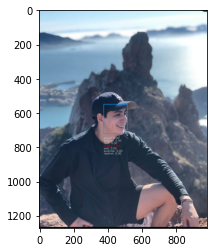

In [48]:
image_path = "https://github.com/joseisaias06/FER_Spotify_Recommender/raw/main/images/face_image12.jpg"
test_image_one = plt.imread(image_path,format="jpg")
emo_detector = FER(mtcnn=True)
captured_emotions = emo_detector.detect_emotions(test_image_one)


# Print all captured emotions with the image

bounding_box = captured_emotions[0]["box"]
emotions = captured_emotions[0]["emotions"]
cv2.rectangle(test_image_one,(
  bounding_box[0], bounding_box[1]),(
  bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0, 155, 255), 2,)

emotion_name, score = emo_detector.top_emotion(test_image_one)
mood = emotion_name
for index, (emotion_name, score) in enumerate(emotions.items()):
  color = (211, 211,211) if score < 0.07 else (255, 0, 0)
  emotion_score = "{}: {}".format(emotion_name, "{:.2f}".format(score))

  cv2.putText(test_image_one,emotion_score,
              (bounding_box[0], bounding_box[1] + bounding_box[3] + 30 + index * 15),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,color,1,cv2.LINE_AA,)


plt.imshow(test_image_one)
print(captured_emotions)
plt.show()


Para seleccionar el tipo de canciones para cada mood, nos basamos en las características de 'Energy' y 'Valence' de cada canción, guiados por Circumplex Model of Affect(Russell 1980).

Dependiendo del estado de ánimo, creamos un vector con determinados valores con el que prodemos calcular la distancia y obtener las canciones más adecuadas.

In [36]:
top_tracks_df['mood_vector'] = top_tracks_df[['valence','energy']].values.tolist()
if mood == 'happy':
    track_moodvec = np.array([1, 1])
elif mood == 'sad':
    track_moodvec = np.array([0, 0.0])
elif mood == 'angry':
    track_moodvec = np.array([0.35, 0.75])
elif mood == 'disgust':
    track_moodvec = np.array([0.42, 0.9])
elif mood == 'fear':
    track_moodvec = np.array([0.3, 0.5])
elif mood == 'surprise':
    track_moodvec = np.array([0.55, 0.8])
elif mood == 'neutral':
    track_moodvec = np.array([0.6, 0.45])
    
#Calculamos las distancias para cada canción    
top_tracks_df['distances'] = top_tracks_df['mood_vector'].apply(lambda x: norm(track_moodvec-np.array(x)))
emotion_track = top_tracks_df[top_tracks_df['distances'] == top_tracks_df['distances'].min()]

Finalmente, de todas las recomendaciones que obtuvimos anteriormente, elegimos aquellas que más se asemejen al mood, y podemos tomar en cuenta también la popularidad para organizar.

In [49]:
# Crawl valence and arousal of given track
track_moodvec = np.array([emotion_track.valence, emotion_track.energy])

# Compute distances to all reference tracks
tracks_to_add['mood_vector'] = tracks_to_add[['valence','energy']].values.tolist()
tracks_to_add["distances"] = tracks_to_add["mood_vector"].apply(lambda x: norm(track_moodvec-np.array(x)))

# Sort distances from lowest to highest
final_tracks = tracks_to_add.sort_values(by = ["distances"], ascending = [True])

#final_tracks['popularity'] = final_tracks['popularity'] / 100 
print(final_tracks.sort_values(by = "popularity", ascending = False)[['name', 'artist_name']])

#print(final_tracks[['name', 'artist_name']])

                                                   name       artist_name
2039                                       X ÚLTIMA VEZ      Daddy Yankee
1898  Lo Siento BB:/ (with Bad Bunny & Julieta Venegas)             Tainy
1999                                             Sobrio            Maluma
1908                                             DÁKITI         Bad Bunny
1538                                      La Curiosidad       Jay Wheeler
...                                                 ...               ...
1963                                            Sistema     Zion & Lennox
1937                                          Full Moon           Guaynaa
538                                       FUI RECLUTADO   Abraham Vazquez
1995                                              Rueda              Juhn
394                                        Juan Ignacio  La Septima Banda

[287 rows x 2 columns]


C:\Users\luisg\AppData\Local\Temp\ipykernel_17660\1772204668.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_to_add['mood_vector'] = tracks_to_add[['valence','energy']].values.tolist()
C:\Users\luisg\AppData\Local\Temp\ipykernel_17660\1772204668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_to_add["distances"] = tracks_to_add["mood_vector"].apply(lambda x: norm(track_moodvec-np.array(x)))
